# DATEX II Virtual User Forum 15.11.2023 - Developer Session
## Client side code generation with Python

This Jupyter Notebook is a demo on how to use data binding for Python in order to work with DATEX II data without manual handling of the XML format used to encode messages.

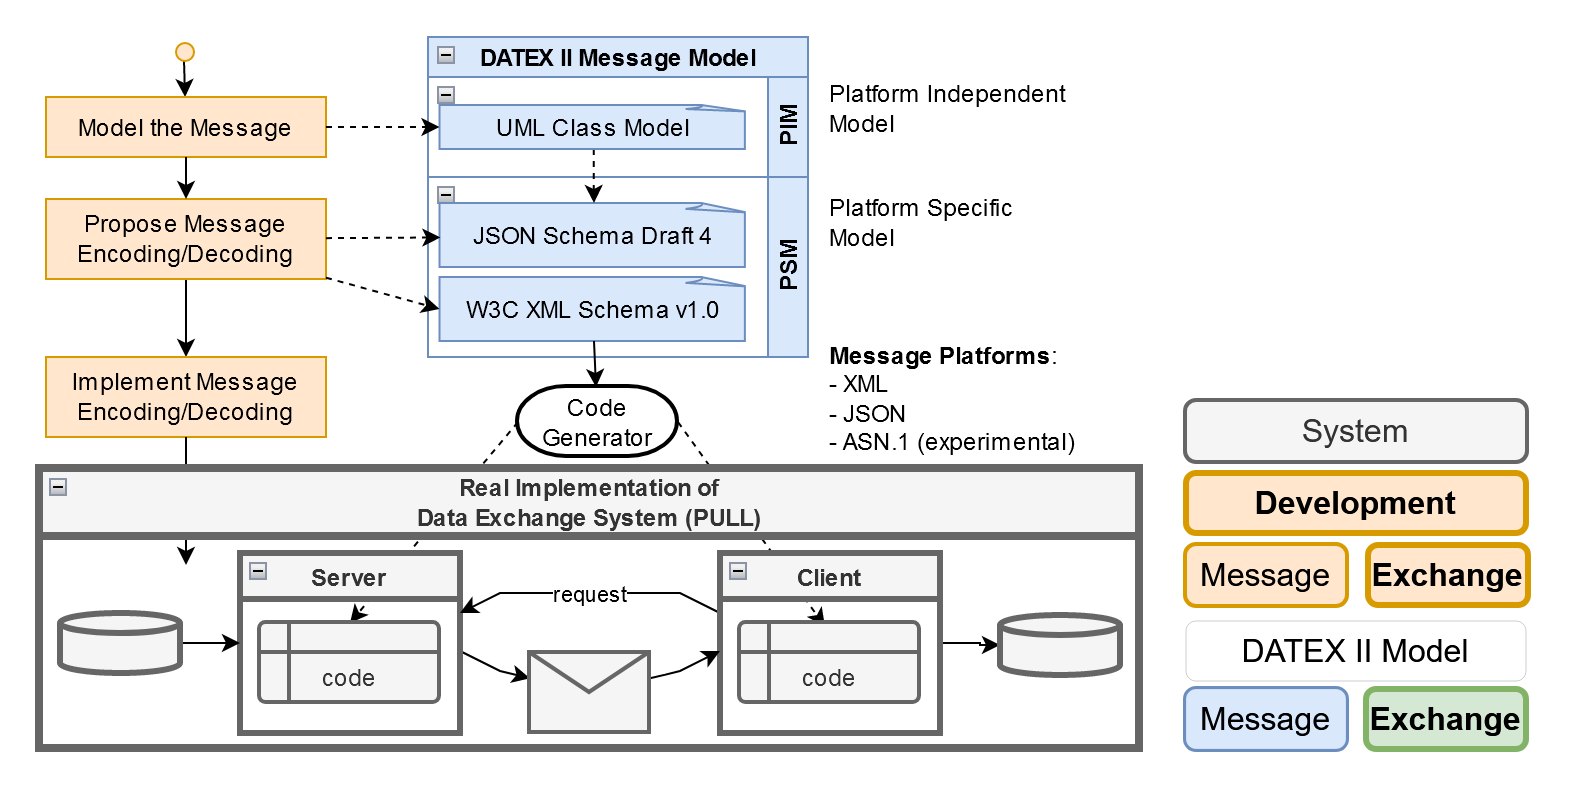

## Generating Python code from XSD files

For this demo we use [xsData](https://xsdata.readthedocs.io/en/latest/) for code generation. If you want to test it out yourself follow the installation instructions on the website. The xsdata library must be installed in the Python environment of the kernel used by this notebook. This sometimes causes confusion, in particular if different Python environments exist on your machine. In case you run into trouble, uncomment and execute the following cell.

In [ ]:
#!pip install xsdata

The next step is to do the code generation from the DATEX II XML Schema Definition (*.xsd) file. These can be created from the profiled Situation DATEX II model exported by Enterprise Architect in the *.xmi format, using the [DATEX II online schema generation tool](https://webtool.datex2.eu/wizard/). You can find the XMI export of the profiled model as well as the generated schemas in the GitHub folder. If you want to create the schemas yourself, you have to load the XMI in the first step and then go through the steps of the tool using the default settings.

We create the code from:
-  the top-level umbrella schema for DATEX II (LevelC_3_D2Payload.xsd)
-  the DATEX II Common library (LevelC_3_Common.xsd)
-  the DATEX II LocationReferencing library (LevelC_3_LocationReferencing.xsd)
-  the DATEX II Situation namespace (LevelC_3_Situation.xsd)

If you have installed the xsData commandline tool, you can now create Python code from the DATEX II schemas. Before doing so, a xsdata configuration file should be created with the following command: 

`xsdata init-config` 

This will create a file named ".xsdata.xml" in your current directory. To ensure that the generated names follow the DATEX II naming conventions, the "FieldName" shall be set to "camelCase" instead of "snakeCase" in the generated xsdata configuration file. To save this change, the command `xsdata init-config` needs to be executed again.

Now you can now create the Python code from the DATEX II schema files by running the following command in the command prompt:

`xsdata generate -ss single-package LevelC_3_D2Payload.xsd`

This will create a "generated.py" file in your current directory, where the created Python code is placed.

## Prerequisites

Import XML parser:

In [1]:
from xsdata.formats.dataclass.parsers import XmlParser

Import the "generated.py" file containing the generated python code

In [2]:
import generated

## Working with the data
The following code cell loads the "instance_Accident.xml" DATEX II instance and parses the xml instance as a DATEX II "PayloadPublication" (see picture below). Usually DATEX II is used for real-time data exchange, so the data would be requested with a HTTP GET request. In this notebook we use a local file, however if you have a datafeed, you can use "data = requests.get('your_url')" instead of loading a local file.

In [24]:
instance = str('instance_Accident.xml')
data = XmlParser().parse(instance,generated.PayloadPublication)

We can now iterate through the DATEX II model using the python classes. Startingt with a "SituationPublication", we can check if there are any "Situation" instances, each containing one or more "SituationRecord" instances. In this demo we are looking at accidents, so the "SituationRecord" instance(s) should be of type Accident.

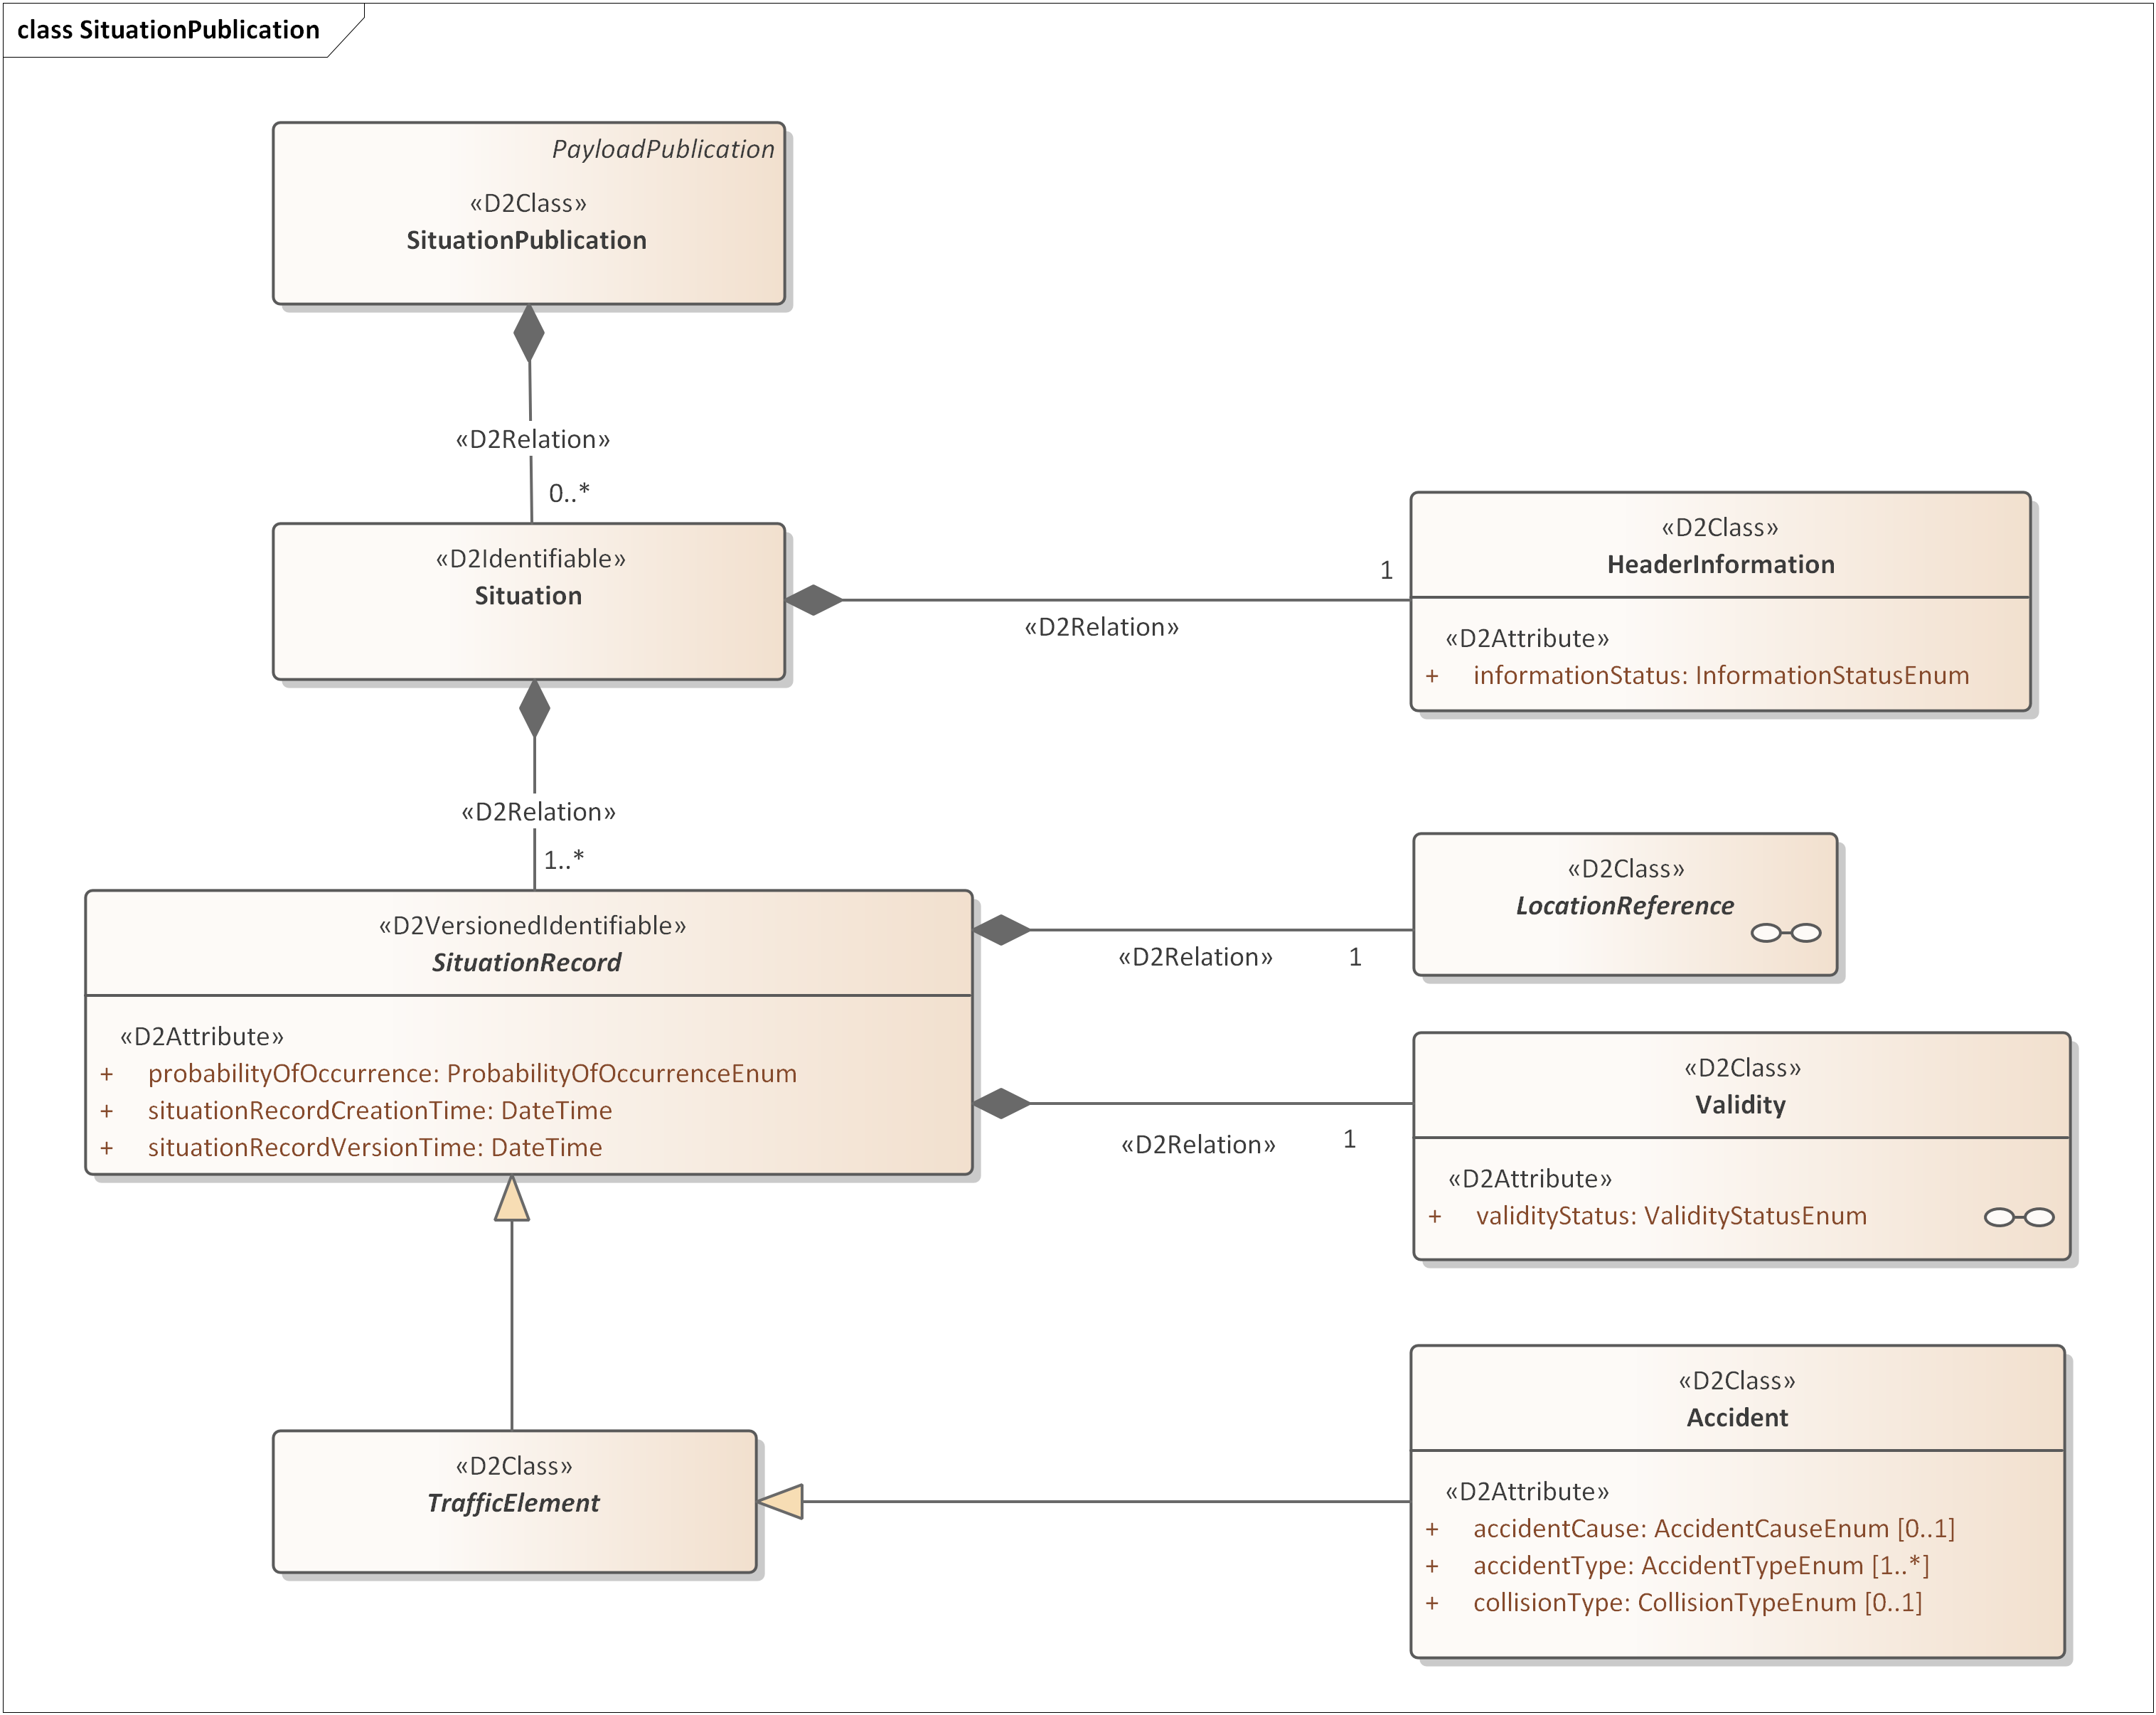

Let's first find out if there are any instances of the "Situation" class in this instance, since the "Situation" class is optional.

In [25]:
situations = data.value.situation
print("There is/are", len(situations), "situations in this instance")

There is/are 3 situations in this instance


Now we know that there are situations contained in the instance, we can further analyse them.
As we see in the diagram above, a situation has some header information including an "informationStatus" attribute. Let's first check the value of that.

Since a "SituationPublication" can have multiple instances of the "Situation" class, we have to iterate through the list of situations, for simplicity in this demo we just take the first situation at position 0 in the list.

In [26]:
informationStatus = situations[0].headerInformation.informationStatus.value.value
print("The information status of the situation is: ", informationStatus)

The information status of the situation is:  real


Since each situation must contain at least one situation record, we can directly access it without having to check it's existence first. However, there might be multiple situation records.

In [7]:
print("There is/are", len(situations[0].situationRecord), "situation records in this instance, of type")

There is/are 1 situation records in this instance, of type


Check the type of the "SituationRecord" to see if it is an accident

In [27]:
print("The SituationRecord is of type:", type(situations[0].situationRecord[0]))

The SituationRecord is of type: <class 'generated.Accident'>


Now that we have found an accident, we can extract further details on that.
As we can see in the diagram above, each accident must have an "accidentType", so we can directly extract the value of that, but the attributes "accidentCause" and "collisionType" are optional, so we first check if the attributes are filled.

In [28]:
accident = situations[0].situationRecord[0]
print("The type of the accident is:", accident.accidentType[0].value.value)
if (accident.accidentCause != None):
    print("The cause of the accident is:", accident.accidentCause.value.value)
else: print("There is no cause specified for this accident!")
if (accident.collisionType != None):
    print("The type of the collision type is:", accident.collisionType.value.value)
else: print("There is no collision type specified for this accident!")

The type of the accident is: collision
There is no cause specified for this accident!
The type of the collision type is: collisionWithAnimal


We can also check the time validity of the accident. As shown above, the time validity is linked to the SituationRecord and has it's own substructure as shown in the diagram below. For this demo, we created a profile of the Validity model.

Since for an accident a start time must be defined, we can simply extract that.

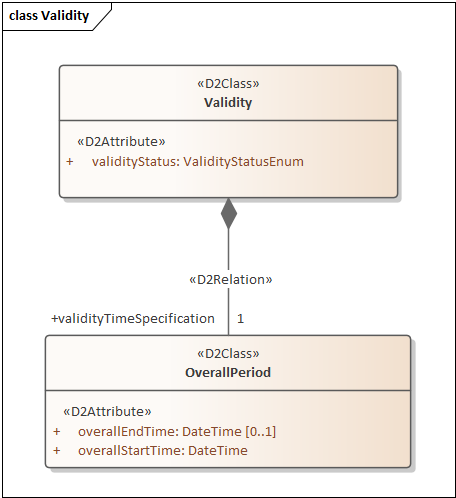


In [29]:
validity = accident.validity.validityTimeSpecification
print("The accident is valid from", validity.overallStartTime)

The accident is valid from 2023-10-30T12:46:17.419693500Z


Finally, we can have a look at the locations of the accident that are defined in the example instance, by extracting either the coordinates for display or the point location (both being point coordinates). For simplicity we choose one, here "coordincatesForDisplay".

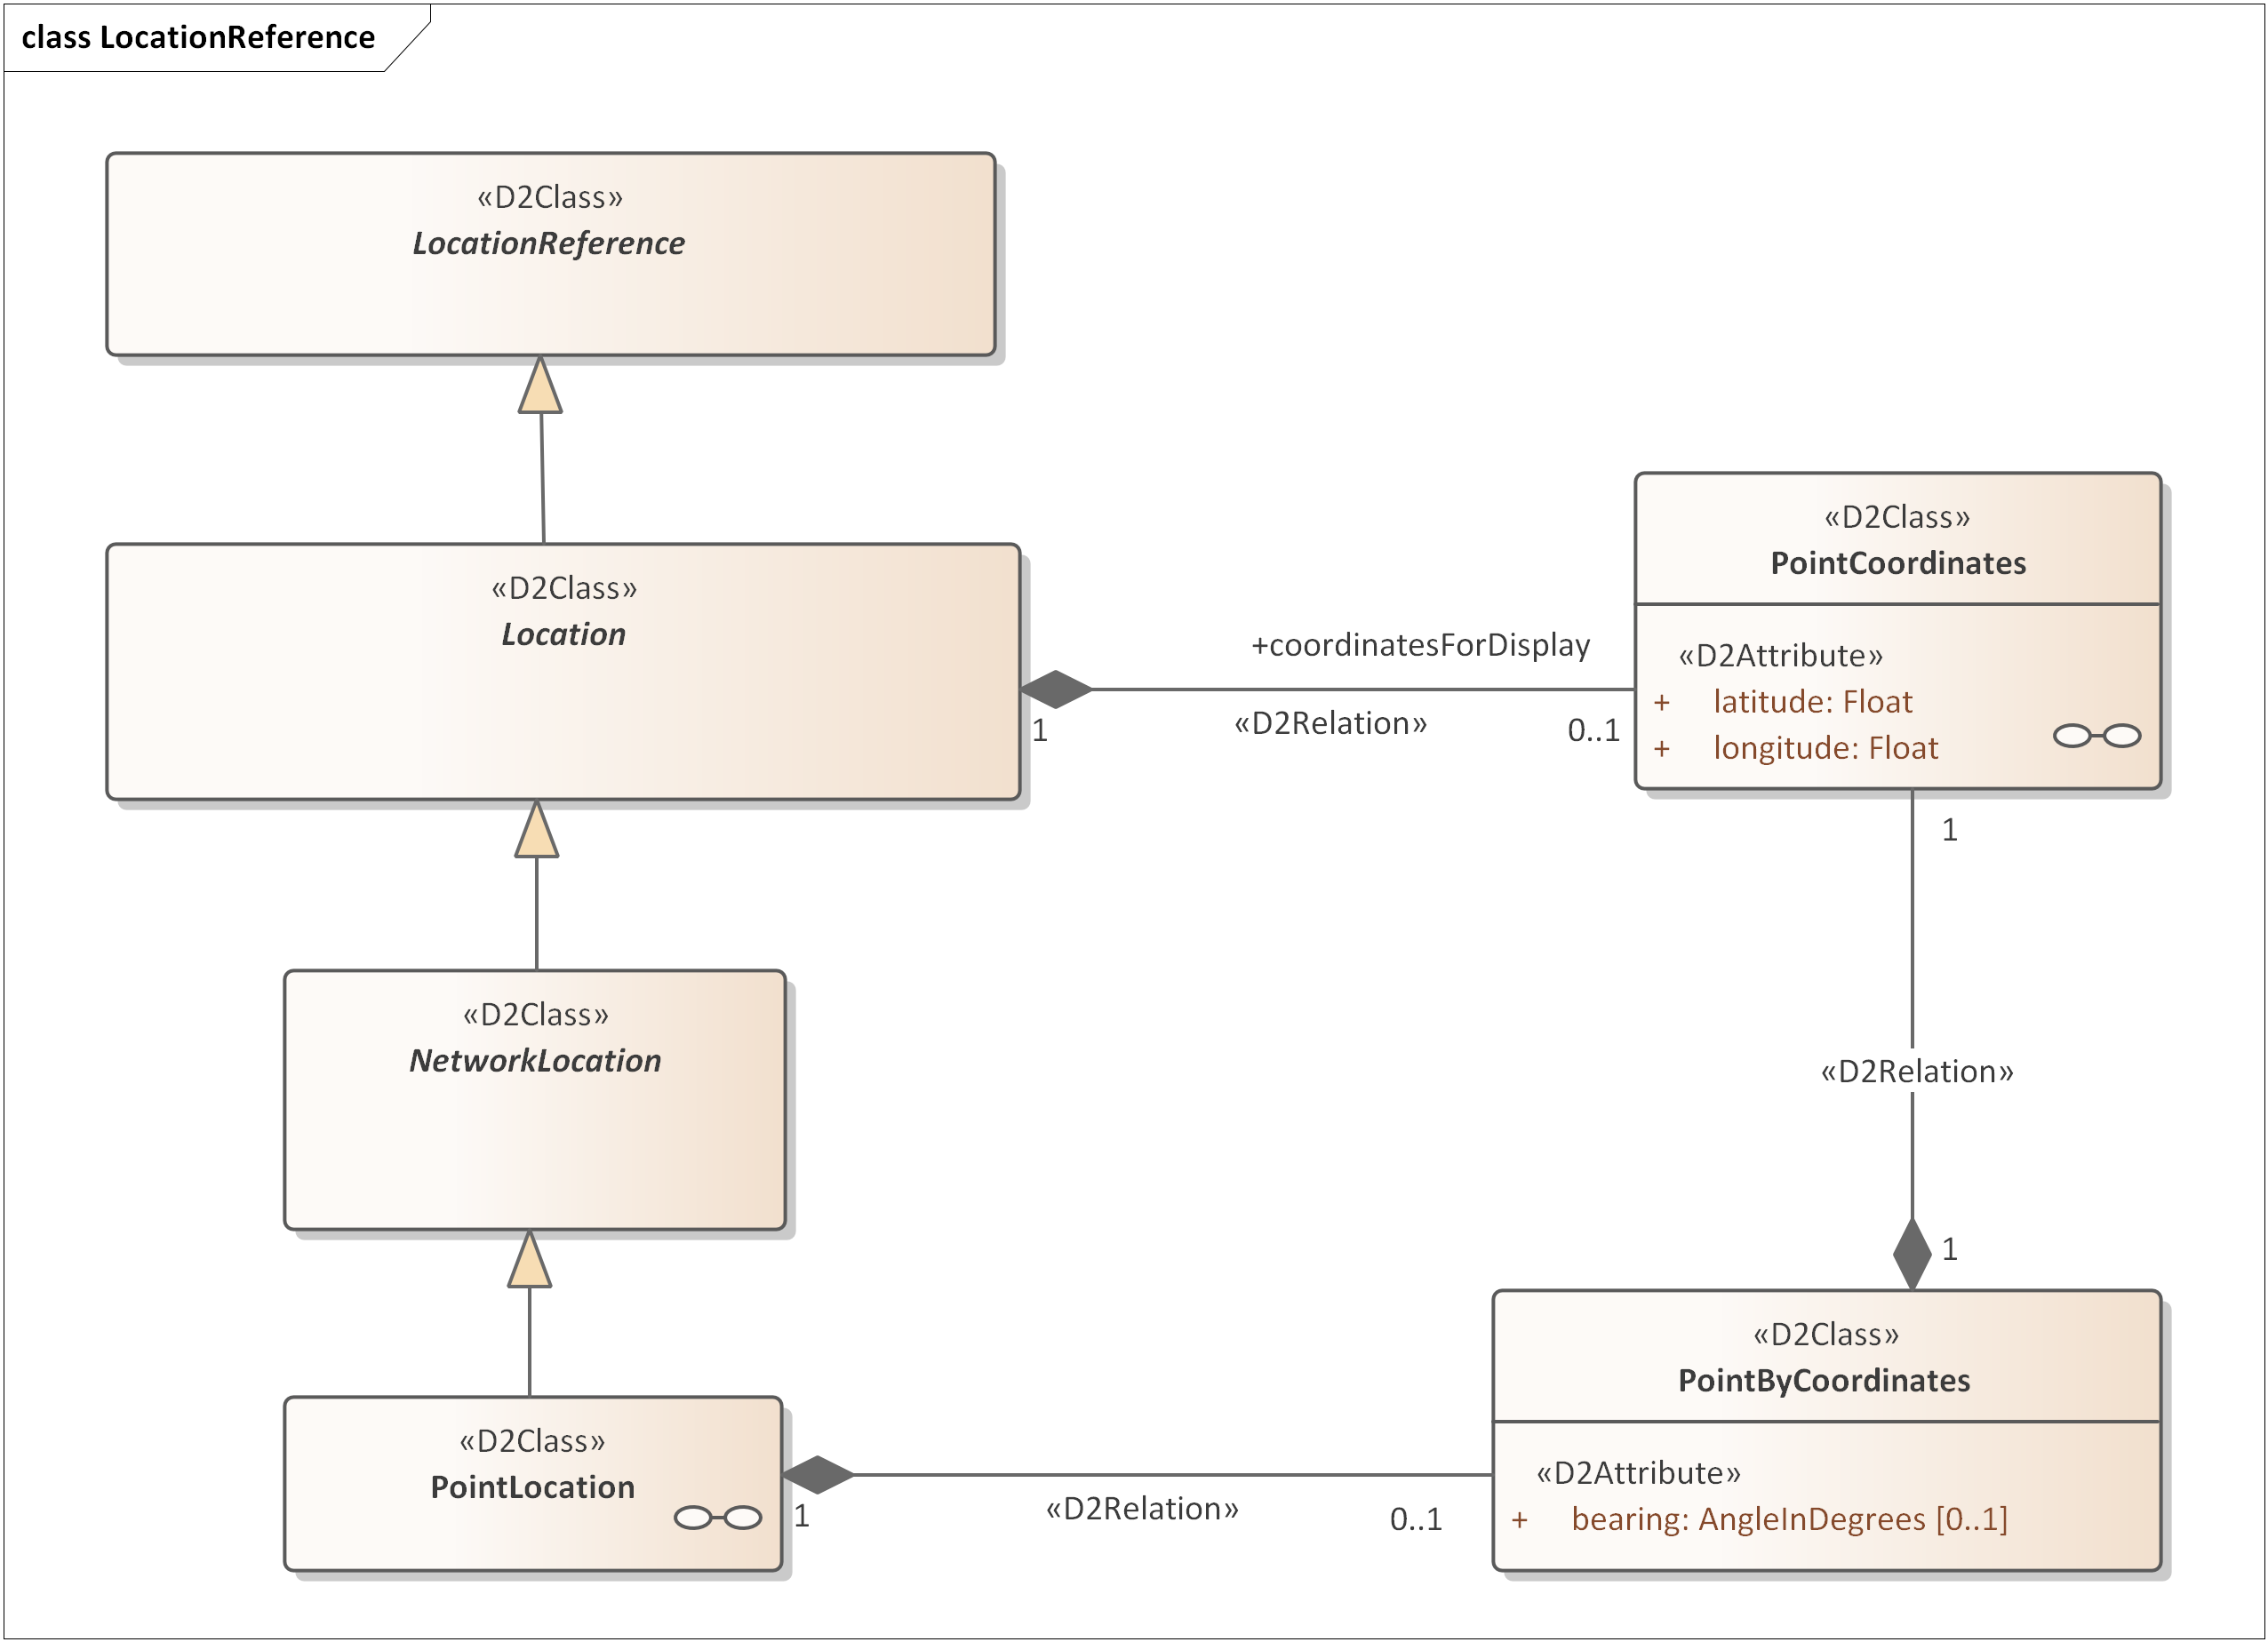

Let's first go through the situations and gather the locations of the accidents.

In [42]:
locations=[]
for s in situations:
    locations.append((s.situationRecord[0].locationReference.coordinatesForDisplay.latitude,s.situationRecord[0].locationReference.coordinatesForDisplay.longitude))
print(locations)

[(53.01894771995707, 5.204404542910014), (52.357929609995075, 4.848115430165523), (52.88900432626247, 5.02553852006629)]


Next, we can show the point location of the accident on an OpenStreetMap using the ipyleaflet python library (uncomment the install statement if you have not installed ipyleaflet on your machine yet).

In [46]:
#!pip install ipyleaflet
from ipyleaflet import Icon, Map, Marker, MarkerCluster
markers = []

for l in locations:
    markers.append(Marker(location=l))

center = (53.0, 7.0)

m = Map(center=center, zoom=7)

marker_cluster = MarkerCluster(markers=markers)

m.add_layer(marker_cluster);
m

Map(center=[53.0, 7.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…